# Bike Sharing Patterns

In [1]:
%matplotlib inline
%load_ext autoreload
%autoreload 2
%config InlineBackend.figure_format = 'retina'

In [2]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt

## Data Preprocessing

### Loading

The data is stored in a CSV file that can be easily loaded with `pandas`:

In [3]:
data_path = 'data/hour.csv'

rides = pd.read_csv(data_path)

In [4]:
rides.head()

,instant,dteday,season,yr,mnth,hr,holiday,weekday,workingday,weathersit,temp,atemp,hum,windspeed,casual,registered,cnt
0,1,2011-01-01,1,0,1,0,0,6,0,1,0.24,0.2879,0.81,0.0,3.0,13.0,16.0
1,2,2011-01-01,1,0,1,1,0,6,0,1,0.22,0.2727,0.80,0.0,8.0,32.0,40.0
2,3,2011-01-01,1,0,1,2,0,6,0,1,0.22,0.2727,0.80,0.0,5.0,27.0,32.0
3,4,2011-01-01,1,0,1,3,0,6,0,1,0.24,0.2879,0.75,0.0,3.0,10.0,13.0
4,5,2011-01-01,1,0,1,4,0,6,0,1,0.24,0.2879,0.75,0.0,0.0,1.0,1.0


### Plotting

The dataset contains the number of rides for each hour of each day from January 1 2011 to December 31 2012. We can have a first look at the data in order to have an idea of its patterns:

Text(0, 0.5, 'Number of Rides')

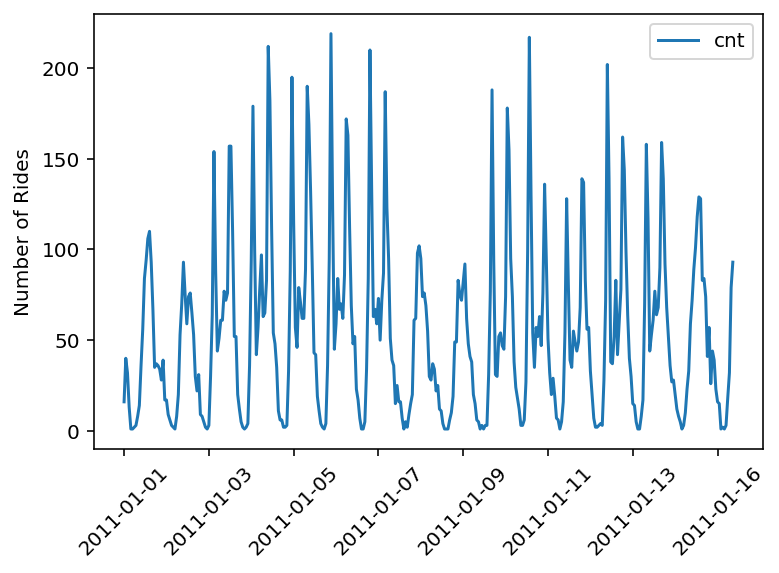

In [5]:
n_days = 15
n_data_per_day = 24 # Usual number of entries per day

rides[:n_days * n_data_per_day].plot(x='dteday', y='cnt')
plt.xticks(rotation=45)
plt.xlabel("")
plt.ylabel("Number of Rides")

### One-Hot Encoding

The dataset contains categorical variables like season, weather, month. To include such variables in the model, we need to transform them into numerical values. Here we can use one-hot encoding (which can be easily obtained with `pd.get_dummies()`):

In [6]:
dummy_cols = ['season', 'weathersit', 'mnth', 'hr', 'weekday']

for col in dummy_cols:
    dummies = pd.get_dummies(rides[col], prefix=col, drop_first=False)
    rides = pd.concat([rides, dummies], axis=1)

data = rides.drop(dummy_cols, axis=1) # Drop one-hot encoded columns
data = data.drop(['instant', 'dteday', 'atemp', 'workingday'], axis=1) # Drop useless columns
data.head()

,yr,holiday,temp,hum,windspeed,casual,registered,cnt,season_1,season_2,...,hr_21,hr_22,hr_23,weekday_0,weekday_1,weekday_2,weekday_3,weekday_4,weekday_5,weekday_6
0,0,0,0.24,0.81,0.0,3.0,13.0,16.0,1,0,...,0,0,0,0,0,0,0,0,0,1
1,0,0,0.22,0.80,0.0,8.0,32.0,40.0,1,0,...,0,0,0,0,0,0,0,0,0,1
2,0,0,0.22,0.80,0.0,5.0,27.0,32.0,1,0,...,0,0,0,0,0,0,0,0,0,1
3,0,0,0.24,0.75,0.0,3.0,10.0,13.0,1,0,...,0,0,0,0,0,0,0,0,0,1
4,0,0,0.24,0.75,0.0,0.0,1.0,1.0,1,0,...,0,0,0,0,0,0,0,0,0,1


### Scaling

To improve training performance we need to scale (standardise) all the continuous variables:

In [7]:
numerical_cols = ['casual', 'registered', 'cnt', 'temp', 'hum', 'windspeed']

# Store scalings in a dictionary so that we can convert back later
scaled_features = {}

for col in numerical_cols:
    mean, std = data[col].mean(), data[col].std()
    scaled_features[col] = [mean, std]
    data.loc[:, col] = (data[col] - mean)/std

### Training, Validation and Test Splitting

In order to test the model, we need to set aside some data. The test set will contain approximately the last `n_days_test` days:

In [8]:
n_days_test=30

# Save data for test
test_data = data[-n_days_test * n_data_per_day:]

# Now remove the test data from the data set 
data = data[:-n_days_test * n_data_per_day]

# Seplit data into features and targets
target_fields = ['cnt', 'casual', 'registered']
features, targets = data.drop(target_fields, axis=1), data[target_fields]
test_features, test_targets = test_data.drop(target_fields, axis=1), test_data[target_fields]

The data not used for testing can be further split in a training set and a validation set. The training set is used to  train the model, while the validation set is used to assess the training performance.

In [9]:
n_days_val=60

# Split train and validation sets
train_features, train_targets = features[:-n_days_val * n_data_per_day], targets[:-n_days_val * n_data_per_day]
val_features, val_targets = features[-n_days_val * n_data_per_day:], targets[-n_days_val * n_data_per_day:]

## Neural Netrowk

In order to predict the bike-sharing pattern based on the data we have, we use a multi-layer perceptron with one hidden layer with a sigmoid activation function. Such neural network is implemented in the class `NeuralNetwork` in `neuralnet.py`.

In [10]:
from neuralnet import NeuralNetwork

In order to assess the performance of the model we need a metric (loss function). Here we use the mean square error(MSE):

In [11]:
def MSE(y, Y):
    return np.mean((y-Y)**2)

## Unit Tests

The correctness of the neural network implementation can be checked with the following unit tests:

In [12]:
import unittest

inputs = np.array([[0.5, -0.2, 0.1]])

targets = np.array([[0.4]])

test_w_i_h = np.array([[0.1, -0.2],
                       [0.4, 0.5],
                       [-0.3, 0.2]])
                       
test_w_h_o = np.array([[0.3],
                       [-0.1]])

class TestMethods(unittest.TestCase):

    def test_activation(self):
        """
        Test activation function
        """

        network = NeuralNetwork(3, 2, 1, 0.5)

        self.assertTrue(np.all(network.activation_function(0.5) == 1/(1+np.exp(-0.5))))

    def test_train(self):
        """
        Test weights update
        """

        network = NeuralNetwork(3, 2, 1, 0.5)

        # Initialise weights
        network.weights_input_to_hidden = test_w_i_h.copy()
        network.weights_hidden_to_output = test_w_h_o.copy()
        
        network.train(inputs, targets)

        self.assertTrue(np.allclose(network.weights_hidden_to_output, 
                                    np.array([[ 0.37275328], 
                                              [-0.03172939]])))

        self.assertTrue(np.allclose(network.weights_input_to_hidden,
                                    np.array([[ 0.10562014, -0.20185996], 
                                              [0.39775194, 0.50074398], 
                                              [-0.29887597, 0.19962801]])))

    def test_run(self):
        """
        Test correctness of run method
        """

        network = NeuralNetwork(3, 2, 1, 0.5)

        # Initialise weights
        network.weights_input_to_hidden = test_w_i_h.copy()
        network.weights_hidden_to_output = test_w_h_o.copy()

        self.assertTrue(np.allclose(network.run(inputs), 0.09998924))

suite = unittest.TestLoader().loadTestsFromModule(TestMethods())
unittest.TextTestRunner().run(suite)

...
----------------------------------------------------------------------
Ran 3 tests in 0.003s

OK


<unittest.runner.TextTestResult run=3 errors=0 failures=0>

## Training

In [13]:
iterations = 5000
learning_rate = 0.5
hidden_nodes = 20
output_nodes = 1

In [14]:
import sys

network = NeuralNetwork(train_features.shape[1], hidden_nodes, output_nodes, learning_rate)

losses = {'train':[], 'validation':[]}
for ii in range(iterations):
    batch = np.random.choice(train_features.index, size=128)

    X, y = train_features.iloc[batch].to_numpy(), train_targets.iloc[batch]['cnt']
                             
    network.train(X, y)
    
    train_prediction = network.run(train_features).T
    train_loss = MSE(train_prediction, train_targets['cnt'].values)

    val_prediction = network.run(val_features).T
    val_loss = MSE(val_prediction, val_targets['cnt'].values)
    
    if ii % 25 == 0:
        sys.stdout.write(f"\rProgress: {100 * ii/iterations:2.1f}%" \
                        + f"... Training loss: {train_loss:.3f}" \
                        + f"... Validation loss: {val_loss:.3f}")
        sys.stdout.flush()
    
    losses['train'].append(train_loss)
    losses['validation'].append(val_loss)

Progress: 99.5%... Training loss: 0.049... Validation loss: 0.213

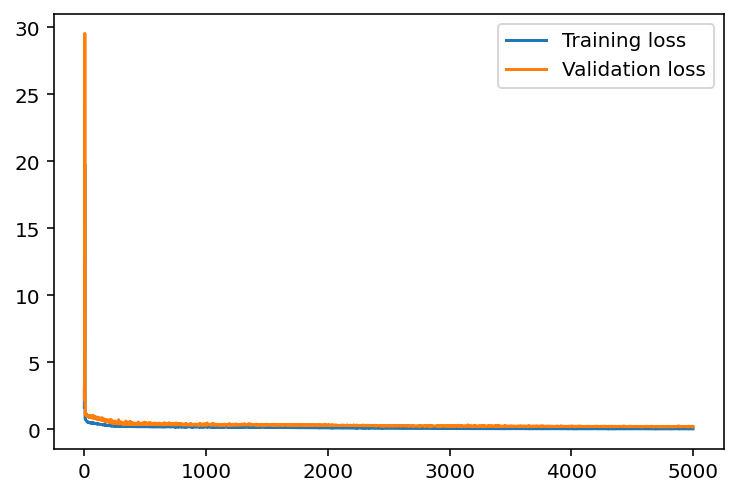

In [15]:
plt.plot(losses['train'], label='Training loss')
plt.plot(losses['validation'], label='Validation loss')
plt.legend()
_ = plt.ylim()

## Visualise Predictions

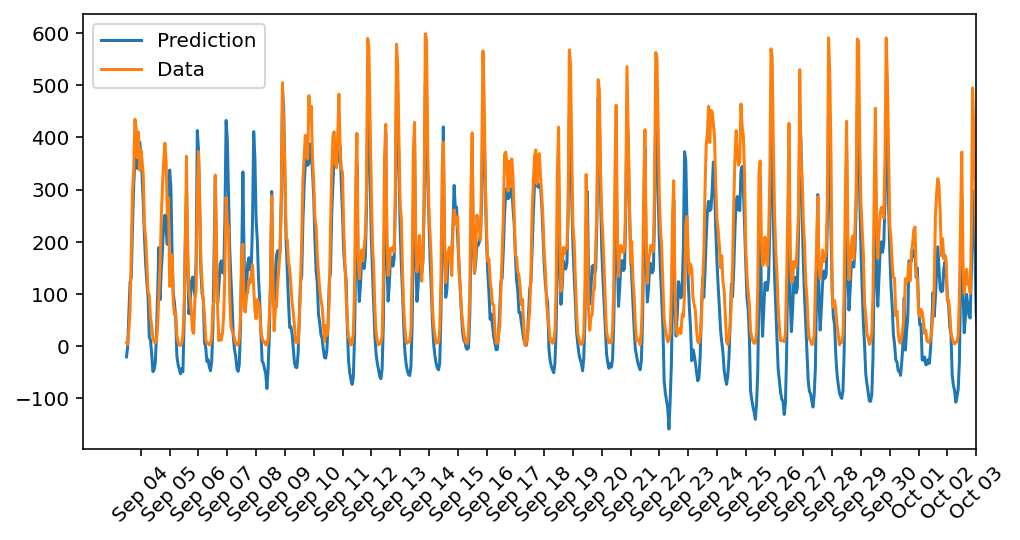

In [16]:
fig, ax = plt.subplots(figsize=(8,4))

mean, std = scaled_features['cnt']
predictions = network.run(test_features).T * std + mean

ax.plot(predictions[0], label='Prediction')
ax.plot((test_targets['cnt']*std + mean).values, label='Data')
ax.set_xlim(right=len(predictions))
ax.legend()

dates = pd.to_datetime(rides.iloc[test_data.index]['dteday'])
dates = dates.apply(lambda d: d.strftime('%b %d'))
ax.set_xticks(np.arange(len(dates))[12::24])
_ = ax.set_xticklabels(dates[12::24], rotation=45)

We see that the model is decent in predicting the location of the differentm maxima and minima. Unfortunately, the actual values of the minima are quite bad, since they represent negative values.